# Import library

In [ ]:
import collections
import re
import numpy as np

from keras.utils.vis_utils import plot_model
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional, Dropout, LSTM, Embedding
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.saving import load_model

# Verify access to GPU

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2024635792983205846
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14328594432
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8732754164451127003
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


# Load data

Dataset: https://www.kaggle.com/datasets/hungnm/englishvietnamese-translation

In [ ]:
# Load English data
english_sentences = []
with open('en_sents.txt', "r") as en_file:
    english_sentences = en_file.read()
english_sentences = english_sentences.split('\n')
en_file.close()

# Load Vietnamese data
vietnamese_sentences = []
with open('vi_sents.txt', "r") as vi_file:
    vietnamese_sentences = vi_file.read()
vietnamese_sentences = vietnamese_sentences.split('\n')
vi_file.close()

In [ ]:
for sample_i in range(5):
    print('English sample {}:  {}'.format(sample_i + 1, english_sentences[sample_i]))
    print('Vietnamese sample {}:  {}'.format(sample_i + 1, vietnamese_sentences[sample_i]))
    print()

English sample 1:  Please put the dustpan in the broom closet
Vietnamese sample 1:  startseq xin vui lòng đặt cái hót rác trong tủ chổi endseq

English sample 2:  Be quiet for a moment.
Vietnamese sample 2:  startseq im lặng một lát endseq

English sample 3:  Read this
Vietnamese sample 3:  startseq đọc này endseq

English sample 4:  Tom persuaded the store manager to give him back his money.
Vietnamese sample 4:  startseq tom thuyết phục người quản lý cửa hàng trả lại tiền cho anh ta. endseq

English sample 5:  Friendship consists of mutual understanding
Vietnamese sample 5:  startseq tình bạn bao gồm sự hiểu biết lẫn nhau endseq



# Vocabulary

In [ ]:
english_words_counter = collections.Counter([word for sentence in english_sentences for word in sentence.split()])
vietnamese_words_counter = collections.Counter([word for sentence in vietnamese_sentences for word in sentence.split()])

print('{} English words.'.format(len([word for sentence in english_sentences for word in sentence.split()])))
print('{} unique English words.'.format(len(english_words_counter)))
print('10 Most common words in the English dataset:')
print('"' + '" "'.join(list(zip(*english_words_counter.most_common(10)))[0]) + '"')
print()
print('{} Vietnamese words.'.format(len([word for sentence in vietnamese_sentences for word in sentence.split()])))
print('{} unique Vietnamese words.'.format(len(vietnamese_words_counter)))
print('10 Most common words in the Vietnamese dataset:')
print('"' + '" "'.join(list(zip(*vietnamese_words_counter.most_common(10)))[0]) + '"')

1721115 English words.
40265 unique English words.
10 Most common words in the English dataset:
"to" "I" "the" "Tom" "a" "you" "is" "of" "in" "was"

2629867 Vietnamese words.
15004 unique Vietnamese words.
10 Most common words in the Vietnamese dataset:
"startseq" "endseq" "tôi" "bạn" "không" "có" "một" "tom" "đã" "của"


# Preprocess

First, remove some special characters (.,?!"), then add 'startseq' and 'endseq' tokens

1. Tokenize the words
2. Add padding to make all the sequences the same length

Finally, create a preprocess pipeline

In [ ]:
# Preprocess the sequence
def remove_special_characters(w):
    '''
    remove_special_characters x
    :param x: a sentence
    :return: the preprocessed sentence
    '''
    # Remove the characters ."?,!
    w = re.sub("[\.\"\?\,\!]", "", w)

    # Add a start and stop token to detect the start and end of the sequence
    w = 'startseq ' + w + ' endseq'

    # Remove duplicate white space
    w = re.sub("(\s+)", " ", w)

    # To lowercase
    w = w.lower()

    return w

In [ ]:
# Demo
str = "I'm told   Tom, \"to clean his room      ?  !       \""
print(f"Before: {str}")
print("After: {}".format(preprocess_sentence(str)))

## Tokenize

In [ ]:
def tokenize(x):
    '''
    Tokenize x
    :param x: List of sentences to be tokenized
    :return: Tuple of (tokenized x data, tokenizer used to tokenize x)
    '''
    # for i in range(len(x)):
    #     x[i] = "startseq " + x[i] + " endseq"
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(x)
    return tokenizer.texts_to_sequences(x), tokenizer

In [ ]:
# Tokenizing demo
text_sentencs = [
    'The quick brown fox jumps over the lazy dog .',
    'By Jove , my quick study of lexicography won a prize .',
    'This is a short sentence .'
]
text_tokenized, text_tokenizer = tokenize(text_sentencs)
print(text_tokenizer.word_index, "\n")
for sample_i, (sent, token_sent) in enumerate(zip(text_sentencs, text_tokenized)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('     Input:  {}'.format(sent))
    print('     Output: {}'.format(token_sent))

{'the': 1, 'quick': 2, 'a': 3, 'brown': 4, 'fox': 5, 'jumps': 6, 'over': 7, 'lazy': 8, 'dog': 9, 'by': 10, 'jove': 11, 'my': 12, 'study': 13, 'of': 14, 'lexicography': 15, 'won': 16, 'prize': 17, 'this': 18, 'is': 19, 'short': 20, 'sentence': 21} 

Sequence 1 in x
     Input:  The quick brown fox jumps over the lazy dog .
     Output: [1, 2, 4, 5, 6, 7, 1, 8, 9]
Sequence 2 in x
     Input:  By Jove , my quick study of lexicography won a prize .
     Output: [10, 11, 12, 2, 13, 14, 15, 16, 3, 17]
Sequence 3 in x
     Input:  This is a short sentence .
     Output: [18, 19, 3, 20, 21]


## Padding

In [ ]:
def padding(x, length=None):
    """
    Padding x
    :param x: List of sequences.
    :param length: Length to pad the sequence to. If None, use length of longest sequence in x.
    :return: Padded numpy array of sequences
    """
    return pad_sequences(x, maxlen=length, padding='post')

In [ ]:
# Padding demo
test_padding = padding(text_tokenized)
for sample_i, (token_sent, padding_sent) in enumerate(zip(text_tokenized, test_padding)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('     Input:  {}'.format(np.array(token_sent)))
    print('     Output: {}'.format(padding_sent))

Sequence 1 in x
     Input:  [1 2 4 5 6 7 1 8 9]
     Output: [1 2 4 5 6 7 1 8 9 0]
Sequence 2 in x
     Input:  [10 11 12  2 13 14 15 16  3 17]
     Output: [10 11 12  2 13 14 15 16  3 17]
Sequence 3 in x
     Input:  [18 19  3 20 21]
     Output: [18 19  3 20 21  0  0  0  0  0]


## Preprocess pipeline

In [ ]:
def preprocess(in_sents, out_sents):
    in_sents = [remove_special_characters(sent) for sent in in_sents]
    out_sents = [remove_special_characters(sent) for sent in out_sents]

    preprocess_in, in_tokenizer = tokenize(in_sents)
    preprocess_out, out_tokenizer = tokenize(out_sents)

    preprocess_in = padding(preprocess_in)
    preprocess_out = padding(preprocess_out)

    return preprocess_in, preprocess_out, in_tokenizer, out_tokenizer

In [ ]:
preprocess_en, preprocess_vi, en_tokenizer, vi_tokenizer = preprocess(english_sentences, vietnamese_sentences)

max_en_sequence_length = preprocess_en.shape[1]
max_vi_sequence_length = preprocess_vi.shape[1]
en_vocab_size = len(en_tokenizer.word_index) + 1 # +1 for padding token
vi_vocab_size = len(vi_tokenizer.word_index) + 1 # +1 for padding token

print('Data Preprocessed')
print("Max English sentence length:", max_en_sequence_length)
print("Max Vietnamese sentence length:", max_vi_sequence_length)
print("English vocabulary size:", en_vocab_size)
print("Vietnamese vocabulary size:", vi_vocab_size)

Data Preprocessed
Max English sentence length: 47
Max Vietnamese sentence length: 63
English vocabulary size: 20809
Vietnamese vocabulary size: 7083


# Models

In [ ]:
embedding_dim = 200
latent_dim = 256

# Encoder Input layer
encoder_inputs = Input(shape=(max_en_sequence_length, ))

# Encoder Embedding layer
encoder_embedding = Embedding(en_vocab_size, embedding_dim, trainable=True)(encoder_inputs)

# Encoder LSTM layer
encoder_lstm = LSTM(latent_dim, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
(encoder_outputs, state_h, state_c) = encoder_lstm(encoder_embedding)

# Decoder: using encoder's final state as the initial state
decoder_inputs = Input(shape=(None, ))

# Decoder Embeddign layer
decoder_embedding_layer = Embedding(vi_vocab_size, embedding_dim, trainable=True)
decoder_embedding = decoder_embedding_layer(decoder_inputs)

# Decoder LSTM layer
decoder_lstm = LSTM(latent_dim, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.2)
(decoder_outputs, decoder_fwd_state, decoder_back_state) = decoder_lstm(decoder_embedding, initial_state=[state_h, state_c])

# Dense layer
decoder_dense = TimeDistributed(Dense(vi_vocab_size, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

In [ ]:
# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 47)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 47, 200)      4161800     ['input_3[0][0]']                
                                                                                                  
 embedding_3 (Embedding)        (None, None, 200)    1416600     ['input_4[0][0]']                
                                                                                            

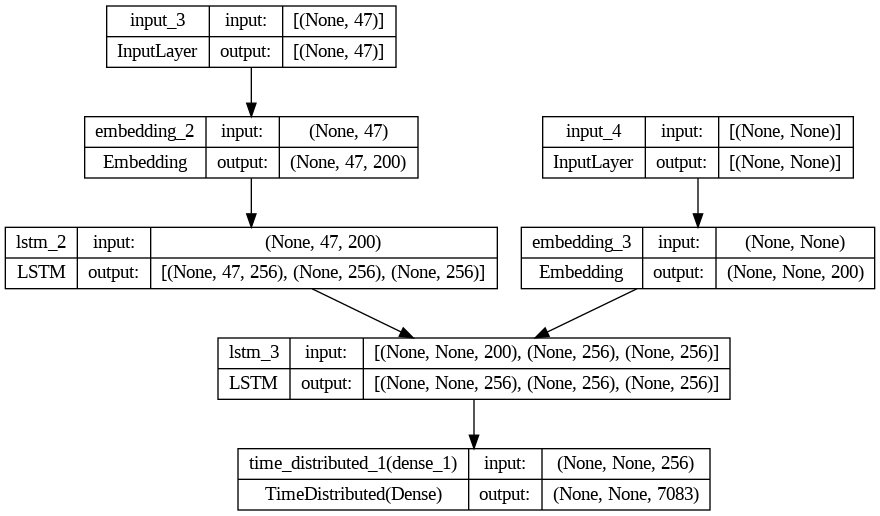

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [ ]:
history = model.fit(
    [preprocess_en, preprocess_vi[:, :-1]],
    preprocess_vi.reshape(preprocess_vi.shape[0], preprocess_vi.shape[1], 1)[:, 1:],
    epochs=10,
    callbacks=[es],
    batch_size=1024,
    validation_split=0.2,
)

Epoch 1/10
199/199 [==============================] - 251s 1s/step - loss: 1.2491 - val_loss: 0.8486
Epoch 2/10
199/199 [==============================] - 222s 1s/step - loss: 0.8307 - val_loss: 0.8243
Epoch 3/10
199/199 [==============================] - 223s 1s/step - loss: 0.8172 - val_loss: 0.8098
Epoch 4/10
199/199 [==============================] - 218s 1s/step - loss: 0.8006 - val_loss: 0.7934
Epoch 5/10
199/199 [==============================] - 217s 1s/step - loss: 0.7885 - val_loss: 0.7851
Epoch 6/10
199/199 [==============================] - 215s 1s/step - loss: 0.7806 - val_loss: 0.7793
Epoch 7/10
199/199 [==============================] - 215s 1s/step - loss: 0.7739 - val_loss: 0.7722
Epoch 8/10
199/199 [==============================] - 215s 1s/step - loss: 0.7673 - val_loss: 0.7651
Epoch 9/10
199/199 [==============================] - 214s 1s/step - loss: 0.7613 - val_loss: 0.7593
Epoch 10/10
199/199 [==============================] - 215s 1s/step - loss: 0.7565 - val_lo

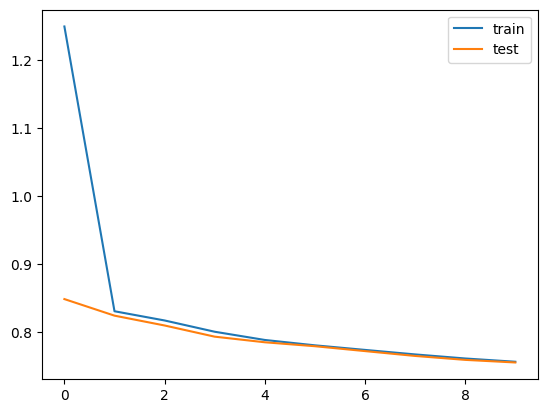

In [ ]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
!mkdir -p saved_model
model.save('saved_model/seq2seq_model.h5')

# Test the model

In [ ]:
model = load_model('saved_model/seq2seq_model.h5')

In [ ]:
# Inference Models

# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs,
                      state_h, state_c])

# Decoder setup

# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim, ))
decoder_state_input_c = Input(shape=(latent_dim, ))
decoder_hidden_state_input = Input(shape=(max_en_sequence_length, latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2 = decoder_embedding_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
(decoder_outputs2, state_h2, state_c2) = decoder_lstm(dec_emb2,
        initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input,
                      decoder_state_input_h, decoder_state_input_c],
                      [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):

    # Encode the input as state vectors.
    (e_out, e_h, e_c) = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = vi_tokenizer.word_index['startseq']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        (output_tokens, h, c) = decoder_model.predict([target_seq]
                + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = vi_tokenizer.index_word[sampled_token_index]

        if sampled_token != 'endseq':
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find the stop word.
        if sampled_token == 'endseq' or len(decoded_sentence.split()) >= max_vi_sequence_length - 1:
            stop_condition = True

        # Update the target sequence (of length 1)
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        (e_h, e_c) = (h, c)

    return decoded_sentence

In [ ]:
# To convert sequence to summary
def seq2summary(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0 and i != vi_tokenizer.word_index['startseq'] and i != vi_tokenizer.word_index['endseq']:
            newString = newString + vi_tokenizer.index_word[i] + ' '

    return newString


# To convert sequence to text
def seq2text(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0:
            newString = newString + en_tokenizer.index_word[i] + ' '

    return newString

In [ ]:
i = 344
print('Review:', seq2text(preprocess_en[i]))
print('Original summary:', seq2summary(preprocess_vi[i]))
print('Predicted summary:', decode_sequence(preprocess_en[i].reshape(1, max_en_sequence_length)))
print()

Review: the jewelry store is open 
Original summary: cửa hàng trang sức mở cửa 
1/1 [==============================] - 0s 23ms/step
Predicted summary:  calais phì zilch calais r chuồn nhếch 35 bỏng sỹ itub võng chiba hemingway hemingway sandwiches nguồn ăn ăn toạc sakaki sakaki sakaki mê mê mê mê kaisha ozone magdalena kaisha soseki g loopy footsie 1971 bạn marika chức giương android chát vẩn sloane vẩn nhảnh nhảnh cộng gin gin 77 mọc mọc mitt dũng ryo qomolangma soprano nhỉ giương chát popsicles

